In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12,4)

# The JPA equations

A driven, parametrically modulated Duffing equation:

$$
\ddot x + \gamma x + \omega_0^2 \big(1 + \epsilon \cos(\omega_p t + \phi)\big) + \alpha x^3= F \cos(\omega_s t)
$$

Note that $\phi$ is only relevant for the so-called "degerate amplifier" condition, $\omega_p = 2 \omega_s$. 

Typically, $\omega_s = \omega_0 + \Delta$, where $\Delta < \gamma$. And $\omega_p = 2\omega_0$ (first order parametric resonance condition). 

We will pick $\omega_0 = 1$:

$$
\ddot x + \gamma x + \big(1 + \epsilon \cos(\omega_p t + \phi)\big) + \alpha x^3 = F \cos(\omega_s t)
$$

# Coding them

In [3]:
def solve_and_plot():
    # State vector y: 
    # y[0] = x
    # y[1] = v

    def dydt(t,y):
        x = y[0]
        v = y[1]
        dxdt = v
        dvdt = (F*np.cos(ws*t) - gam*v - x*(1+eps*np.cos(wp*t+phi)) - alpha*x**3)
        return (dxdt, dvdt)
    
    t = np.linspace(0,T,N)
    sol = solve_ivp(dydt, [0,T], [0,0], t_eval=t)
    x = sol.y[0]
    plt.plot(t,x)
    return t,x

First, start with something we know should work: the driven HO

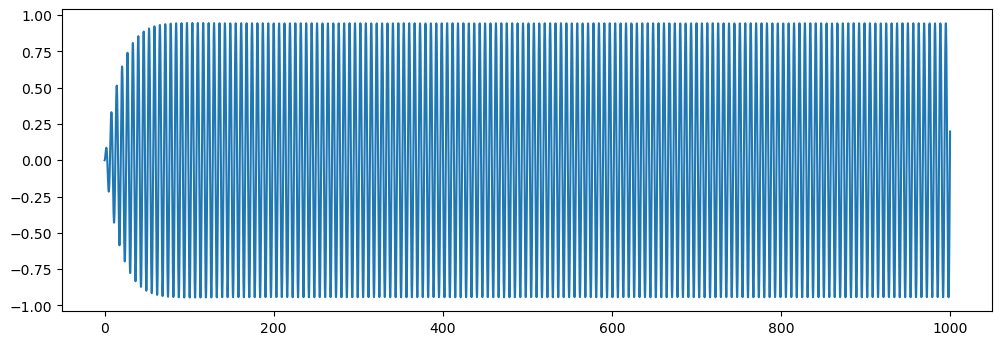

In [4]:
T = 1000
gam = 0.1
eps = 0.0
F = 0.1
alpha = 0 
N = 10000
ws = 0.98
wp = 2
phi = 0
t0,x0 = solve_and_plot()

Now, let's put in parametric modulation in non-degenerate condition: 

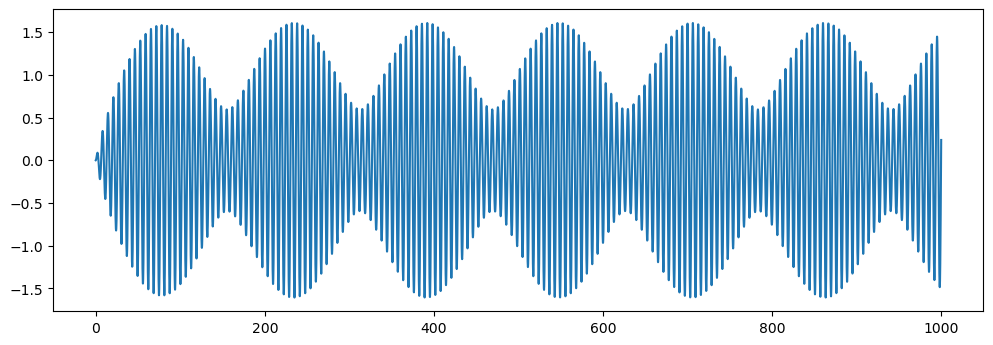

In [5]:
T = 1000
gam = 0.1
eps = 0.1
F = 0.1
alpha = 0 
N = 10000
ws = 0.98
wp = 2
t1,x1 = solve_and_plot()

Now let's add some Duffing and see what happens:

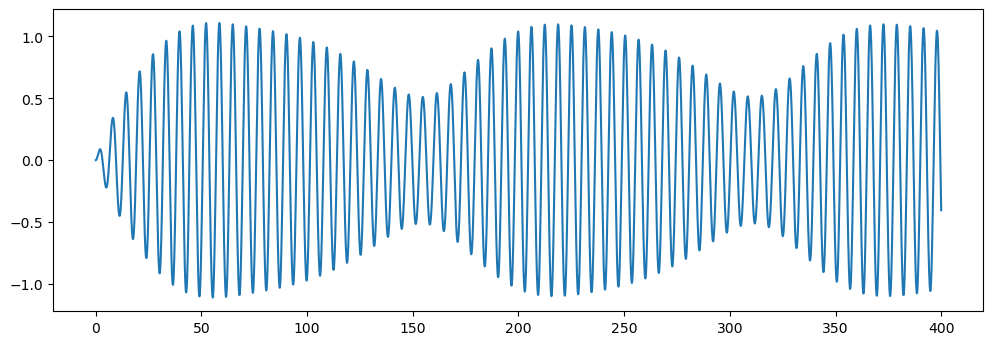

In [20]:
T = 400
gam = 0.1
eps = 0.1
F = 0.1
alpha = 0.1
N = 100000
ws = 0.98
wp = 2
t2,x2 = solve_and_plot()

Here, we can see saturation already:

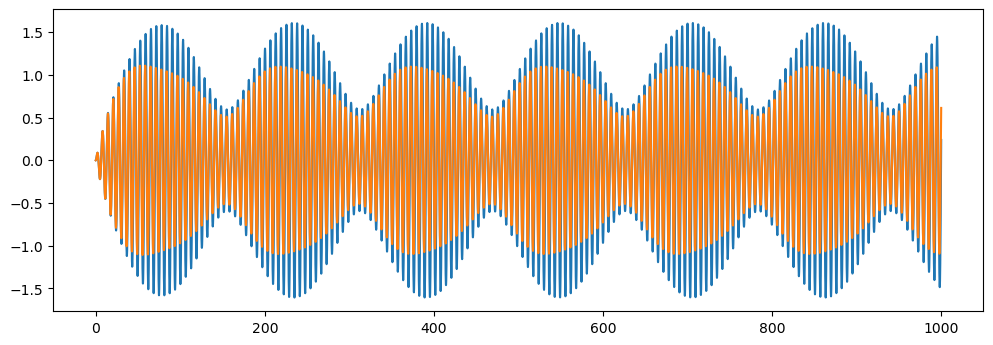

In [283]:
plt.plot(t1,x1)
plt.plot(t2,x2)

# Spectral analysis of the results

In [284]:
def plot_spec(x, lab=""):
    Nf = len(x)*10
    xf = np.fft.fft(x, Nf)
    w = np.fft.fftfreq(Nf, d = T/(N-1))*2*np.pi
    xf = xf[0:N//2]
    w = w[0:N//2]
    plt.plot(w,np.abs(xf)**2, label=lab)
    plt.xlim(0.9,1.2)

Text(1.063, 29000000.0, 'Second Idler (Upper)')

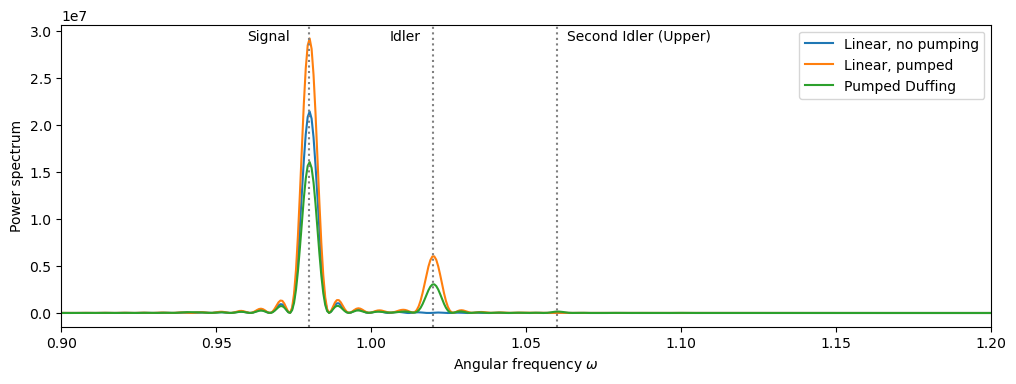

In [285]:
plot_spec(x0, "Linear, no pumping")
plot_spec(x1, "Linear, pumped")
plot_spec(x2, "Pumped Duffing")
plt.axvline(0.98, ls=":", c='grey')
plt.axvline(1.02, ls=":", c='grey')
plt.axvline(1.06, ls=":", c='grey')
plt.legend()
plt.xlabel("Angular frequency $\omega$")
plt.ylabel("Power spectrum")
plt.text(0.96, 2.9e7, "Signal")
plt.text(1.006, 2.9e7, "Idler")
plt.text(1.063, 2.9e7, "Second Idler (Upper)")

We also see the appearance of a second idler sideband at higher frequencies due to higher order mixing. 

# Higher gain?

Let's try to get higher gain. 

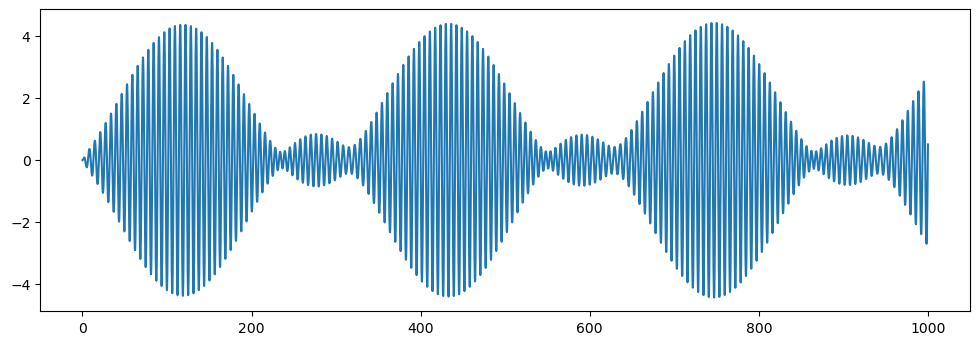

In [21]:
T = 1000
gam = 0.1
eps = 0.2
F = 0.1
alpha = 0 
N = 10000
ws = 0.98
wp = 2
t,x = solve_and_plot()

This is strange. This is not a lot of gain (Wouter gets 30 dB = power factor 1000, voltage factor 31) and now weird stuff is starting to happen. 

Probably epsilon is too large? 

Maybe we need higher Q: this will give us more gain at smaller epsilon. Go resonant and adjust force so that the resonant amplitude is 1.

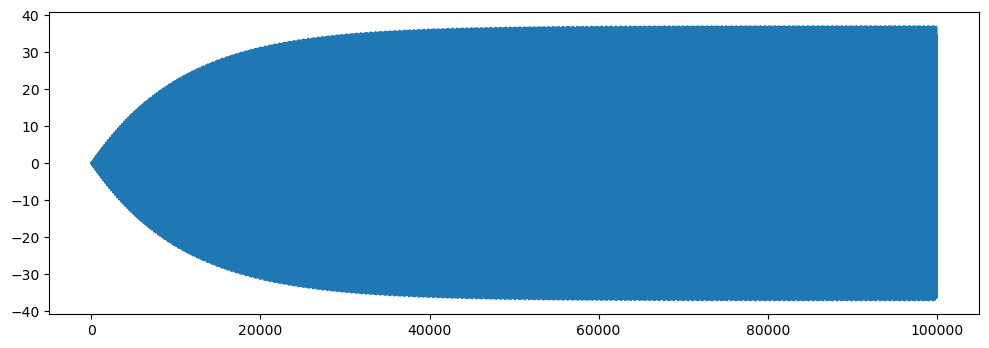

In [286]:
T = 100000
gam = 0.01
eps = 0.0197
F = 0.01
alpha = 0 
N = 10000
ws = 1
wp = 2
t1,x1 = solve_and_plot()

OK, that is now high gain. 

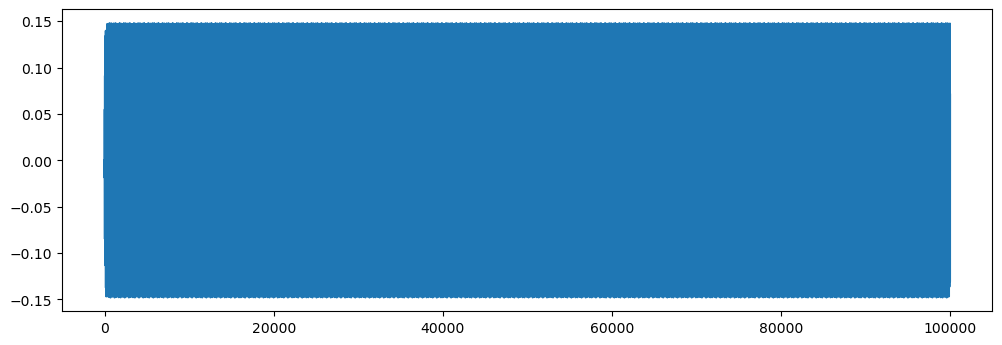

In [287]:
T = 100000
gam = 0.1
eps = 0.1
F = 0.01
alpha = 0 
N = 10000
ws = 1
wp = 2
t1,x1 = solve_and_plot()

And, of course, as we go to higher and higher gain, we need to wait longer and longer for the system to reach steady state, which make sense in terms of the pumpistor model: the effect of the negative internal resistance is increase the quality factor! 

# Parametric instability and limit cycles based on Duffing NL

Note that if we go just a little bit further, we end up in self oscillation (exponential growth of the solution): 

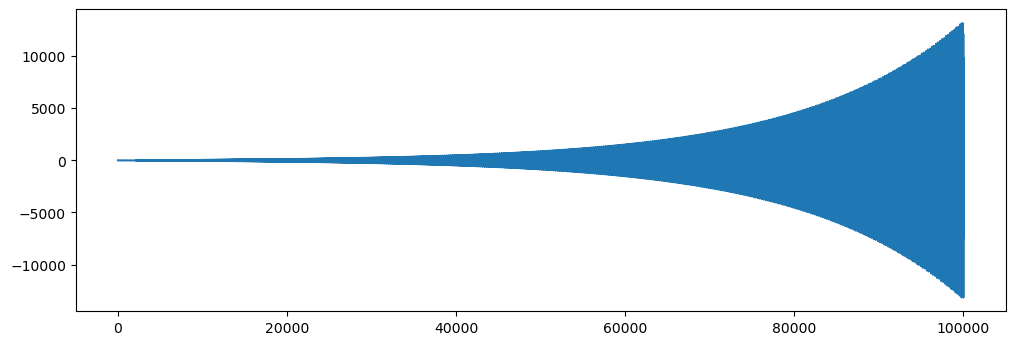

In [219]:
T = 100000
gam = 0.1
eps = 0.2
F = 0.01
alpha = 0 
N = 10000
ws = 1
wp = 2
t1,x1 = solve_and_plot()

And, now, if we include some nonlinearity, we will truncate this growth and reach a limit cycle:

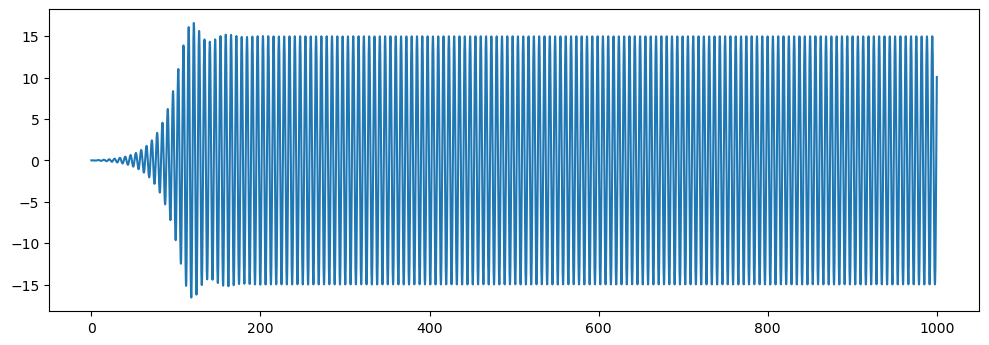

In [228]:
T = 1000
gam = 0.1
eps = 0.4
F = 0.01
alpha = 0.001
N = 10000
ws = 1
wp = 2
t1,x1 = solve_and_plot()

(0.0, 500.0)

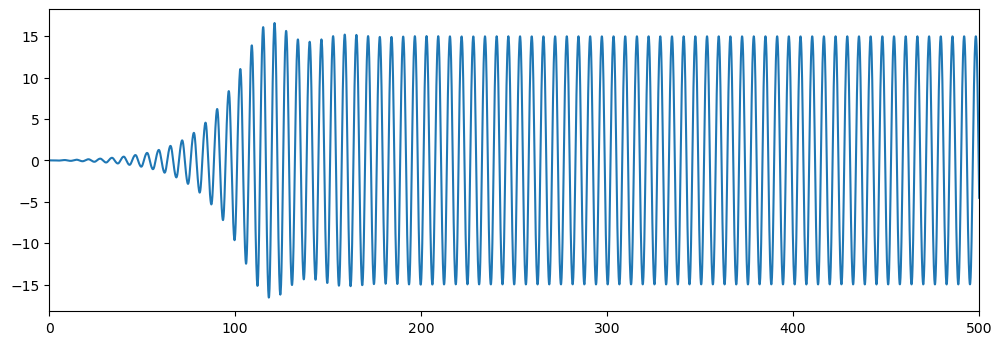

In [229]:
plt.plot(t1,x1)
plt.xlim(0,500)

# A vectorised sweep

Let's try a relatively simple sweep: we well keep the resonant pump/signal condition, and then sweep them through the cavity resonance. 

From: 

https://github.com/gsteele13/gary-misc-notebooks/blob/master/Vectorised%20Numerical%20Integration%20with%20Scipy.ipynb

In [249]:
T = 1000
gam = 0.1
eps = 0.1
F = 0.1
alpha = 0 
N = 10000

Nw = 500
ws = np.geomspace(0.9,1.1,Nw)
wp = 2*ws

def solve_vector():
    # The trick is: we need 
    def dydt_vector(t,y):
        x = y[:len(y)//2]
        v = y[len(y)//2:]
        dxdt = v
        dvdt = (F*np.cos(ws*t) - gam*v - x*(1+eps*np.cos(wp*t+phi)) - alpha*x**3)
        return np.concatenate([dxdt,dvdt],axis=None)

    T = 300
    ts = 0.1
    Nt = int(T/ts)
    t = np.linspace(0,T,Nt)

    x0 = np.zeros(Nw)
    v0 = np.zeros(Nw)
    y0 = np.concatenate([x0,v0],axis=None)

    sol = solve_ivp(dydt_vector, [0,T], y0, t_eval=t)
    x = sol.y[:len(sol.y)//2]
    amp = np.max(x[:,int(len(sol.y)*0.9):], axis=1) # A hack: manually tweaked to find reasonable steady state
    return ws, amp

In [271]:
res = []
for eps in np.linspace(0,0.18, 10):
    res.append(solve_vector())

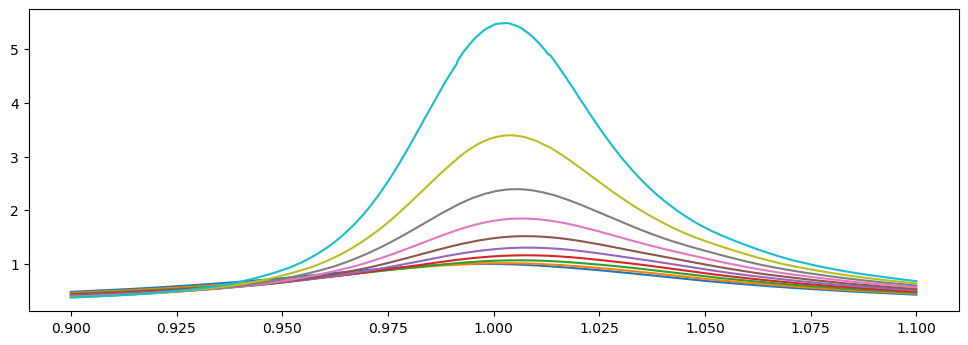

In [272]:
for r in res:
    plt.plot(r[0], r[1])

Note that by eps = 0.18, I am not 100% we're hitting steady state. The higher gain traces may require longer numerical integration and a smarter steady state extraction to reach steady state. 

# Harmonic Balance
Let's git Mousai a chance at this. 

First, define the state derivative function (as you did).

See this [example](https://josephcslater.github.io/mousai/tutorial/demos/Theory_and_Examples.html). Mousai's "style" matches the older function format previously used by SciPy. SciPy changed that compatibility. 

In [58]:
import mousai as ms
from numpy import pi, sin, cos # imported to ensure my Mousai examples work- they do

In [25]:
def dydt_mousai(y, params):
        x = y[0]
        v = y[1]
        omega = params['omega'] # Not using it here, but it's used elsewhere in Mousai
        # I'm being lazy and leaving it in as i can't recall enough how it might cause 
        # problems to leave it out. 
        t = params['cur_time']  # this is how Mousai "gets" time into the function
        dxdt = v
        dvdt = (F*np.cos(ws*t) - gam*v - x*(1+eps*np.cos(wp*t+phi)) - alpha*x**3)
        return np.array([[dxdt], [dvdt]])

Define some parameters. 

phi was missing in the equations above and this wouldn't run, so I'm setting it to zero. 

I'm also not editing parameters that shouldn't matter.

In [22]:
T = 1000
phi = 0
gam = 0.1
eps = 0.0
F = 0.1
alpha = 0 
N = 10000
ws = 0.98
wp = 2
t = np.linspace(0,T,N)

Given $\omega_s$ and $\omega_p$ are multiples of 0.02, we will use that as the fundamental harmonic. 

Mousai will use a Fourier series with a fundamental frequency of 0.02 rad/sec. It will require 100 harmonics to include both $\omega_s$ and $\omega_p$. Understanding the problem a bit better now, I'm very concerned that we will be solving for so many harmonics that this may not have the efficiency I had hoped. In theory, it wouldn't work, but numerical realities will be a big concern. 

Constant term of FFT of signal should be zero:  (6.994502295132321e-07-0j)


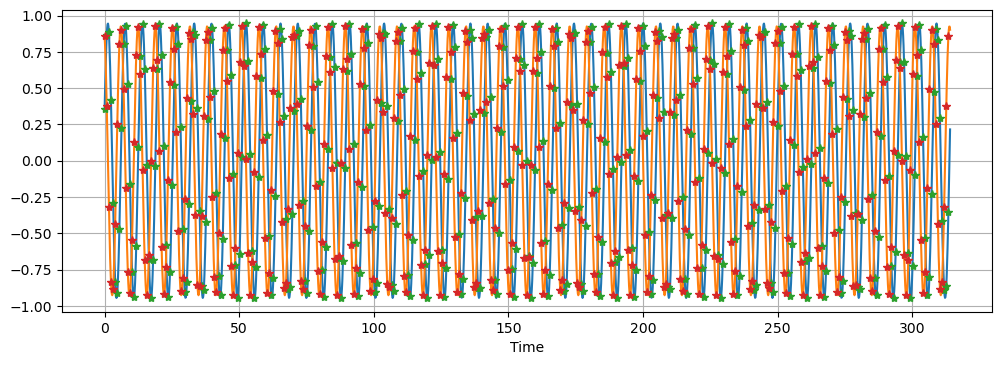

In [62]:
t, x, e, amps, phases = ms.hb_time(dydt_mousai, num_variables=2, omega=0.02,
                                 eqform='first_order', num_harmonics=200)

# print(x,e)
print('Constant term of FFT of signal should be zero: ', ms.fftp.fft(x)[0,0])
time, xc = ms.time_history(t,x, num_time_points=2000)

####
# The time_history function can crash when using a high number of harmonics. 
# num_time_points should be manually inreased
####

plt.plot(time, xc.T, t, x.T, '*')
plt.xlabel('Time')
plt.grid(True)